<a href="https://colab.research.google.com/github/Bas-99/AutoGraderProject/blob/master/TensorFlowTrainingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Below, all relevant packeges are imported.

In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
 
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras.metrics as km
 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix

Now the videos from the dataset in Google Drive are read and given labels, where X are the arrays containing the frames and y are the arrays containing the labels.

In [2]:
data_dir = "/content/drive/MyDrive/VideoData/SecondCustomDataSet/test2"
img_height , img_width = 64, 64
seq_len = 350
 
classes = ["correct","incorrect"]
 
#  Creating frames from videos
 
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
 
    while count <= seq_len: 
         
        success, image = vidObj.read() 
        if success:
            image = cv2.resize(image, (img_height, img_width))
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
 
            
    return frames_list
 
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
           frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
           if len(frames) == seq_len:
                X.append(frames)
             
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
     
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y
 
X, Y = create_data(data_dir)

incorrect
correct


In [3]:
print(len(X))

28


The shape of the tensorflow model is setup: 20 % of the data is used for testing, a ConvLSTM is used as base of the model.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, shuffle=True, random_state=0)
 
model = Sequential()
model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, img_height, img_width, 3)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation = "softmax"))
 
model.summary()
 
opt = tf.keras.optimizers.SGD(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
 
earlystop = EarlyStopping(patience=20)
callbacks = [earlystop]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               62980352  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 63,135,490
Trainable params: 63,135,490
Non-trainable params: 0
____________________________________________

The piece of code below trains the model and shows the real time training results.

In [6]:
history = model.fit(x = X_train, y = y_train, epochs= 50, batch_size = 2 , shuffle=True, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
9/9 [==============================] - 18s 2s/step - loss: 0.6472 - accuracy: 0.6471 - val_loss: 0.5918 - val_accuracy: 0.8000
Epoch 2/50
9/9 [==============================] - 18s 2s/step - loss: 0.4781 - accuracy: 0.7647 - val_loss: 0.4140 - val_accuracy: 0.8000
Epoch 3/50
9/9 [==============================] - 18s 2s/step - loss: 0.4828 - accuracy: 0.8235 - val_loss: 0.4751 - val_accuracy: 0.8000
Epoch 4/50
9/9 [==============================] - 19s 2s/step - loss: 0.5162 - accuracy: 0.7059 - val_loss: 0.4230 - val_accuracy: 0.8000
Epoch 5/50
9/9 [==============================] - 19s 2s/step - loss: 0.5758 - accuracy: 0.8235 - val_loss: 0.4800 - val_accuracy: 0.8000
Epoch 6/50
9/9 [==============================] - 18s 2s/step - loss: 0.4059 - accuracy: 0.9412 - val_loss: 0.3836 - val_accuracy: 0.8000
Epoch 7/50
9/9 [==============================] - 18s 2s/step - loss: 0.3283 - accuracy: 0.8824 - val_loss: 0.3708 - val_accuracy: 0.8000
Epoch 8/50
9/9 [==================

This piece of code will save the current model to the chosen directory.

In [7]:
# Save the model
filepath = "/content/drive/MyDrive/saved_tensorflow_models/SecondTestSetup/test2"
tf.keras.models.save_model(model, filepath)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_tensorflow_models/SecondTestSetup/test2/assets


This piece of code loads this model and shows the model summary.

In [8]:
# Load the model
filepath = "/content/drive/MyDrive/saved_tensorflow_models/SecondTestSetup/test2"
new_model = load_model(filepath, compile=True)

new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 62, 62, 64)        154624    
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 246016)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               62980352  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 63,135,490
Trainable params: 63,135,490
Non-trainable params: 0
____________________________________________

Now the accuracy of the loaded model is shown.

In [9]:
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

print(new_model.predict(X_test).shape)

1/1 - 2s - loss: 0.1688 - accuracy: 1.0000
Restored model, accuracy: 100.00%
(6, 2)


Below, a visual example is given on testing the training data, this can be used to validate the accuracy of the model.

In [23]:
test_sample = 12
samples_to_predict = []
samples_to_predict.append(X_train[test_sample])

samples_to_predict = np.array(samples_to_predict)
print(samples_to_predict.shape)

(1, 350, 64, 64, 3)


In [24]:
predictions = model.predict(samples_to_predict)

classif = np.argmax(predictions, axis = 1)
 
#print(classification_report(y_pred))
print(classif.astype(int))
print(classes[classif[0]])

[0]
correct


In [25]:
video = X_train[test_sample]

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())

Below the graphs are given to compute the categorical crossentropy and the accuracy of the model.

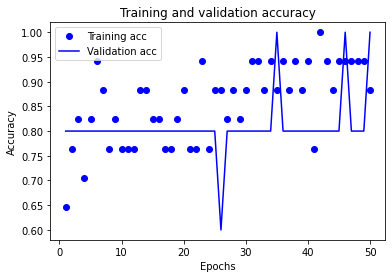

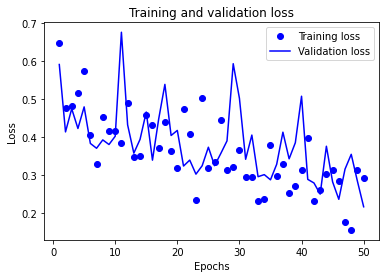

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig1 = plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

fig1.savefig('test2_acc.png', dpi=fig1.dpi)

fig = plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()
fig.savefig('test2_loss.png', dpi=fig.dpi)